In [1]:
%pylab inline
import pandas as pd

from mpl_toolkits.axes_grid.inset_locator import inset_axes

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

results = pd.read_csv('BC_final_results.csv', index_col=0)
ms_results = pd.read_csv('BC_MS_results.csv', index_col=0)
sample_info = pd.read_csv('BC_sample_info.csv', index_col=0)

df = pd.read_table('data/Layer2_BC_count_matrix-1.tsv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

import NaiveDE

dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

Populating the interactive namespace from numpy and matplotlib


In [2]:
res.shape

(250, 12856)

In [4]:
results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)

sres = results.query('qval < 0.05 & g != "log_total_count"').copy()

X = sample_info[['x', 'y']].values

In [5]:
import SpatialDE

In [52]:
histology_results, patterns = SpatialDE.spatial_patterns(X, res, sres, 5, max_iter=20)

INFO:root:Iteration 1, log likelihood: -1216.91
INFO:root:Iteration 2, log likelihood: -1197.05
INFO:root:Iteration 3, log likelihood: -1195.04
INFO:root:Iteration 4, log likelihood: -1195.01
INFO:root:Iteration 5, log likelihood: -1193.45
INFO:root:Iteration 6, log likelihood: -1192.65
INFO:root:Iteration 7, log likelihood: -1191.51
INFO:root:Iteration 8, log likelihood: -1187.26
INFO:root:Iteration 9, log likelihood: -1187.85
INFO:root:Iteration 10, log likelihood: -1187.54
INFO:root:Converged! Finishing...
INFO:root:Iteration 11, log likelihood: -1187.59


In [53]:
K_hat = len(histology_results.pattern.unique())
K_hat

5

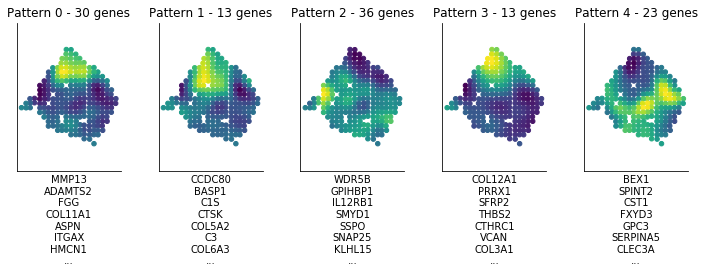

In [54]:
figsize(10, 3.9)
for i, Ci in enumerate(histology_results.sort_values('pattern').pattern.unique()):
    C = patterns[Ci]
    plt.subplot(1, K_hat, i + 1)
    plt.scatter(X[:,0], -X[:,1], c=C, s=20)
    plt.axis('equal')
    plt.title('Pattern {} - {} genes'.format(Ci, histology_results.query('pattern == @Ci').shape[0] ))
    
    xlab = '\n'.join(histology_results.query('pattern == @Ci').sort_values('membership')['g'].tolist()[:7])
    plt.xlabel(xlab + '\n...')
    
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.savefig('BC_AEH.pdf', bbox_inches='tight')

In [55]:
for i in histology_results.sort_values('pattern').pattern.unique():
    
    print('Pattern {}'.format(i))
    print(', '.join(histology_results.query('pattern == @i').sort_values('membership')['g'].tolist()))
    print()

Pattern 0
MMP13, ADAMTS2, FGG, COL11A1, ASPN, ITGAX, HMCN1, GBP1, LRRC15, CRISPLD2, CXCL9, CILP, GJA1, FCGR3A, LOX, ANTXR1, SULF1, TNC, COL5A1, SPP1, COL10A1, PALLD, MMP11, B2M, TMSB4X, MAFB, SOD2, TGM2, RARRES1, FGB

Pattern 1
CCDC80, BASP1, C1S, CTSK, COL5A2, C3, COL6A3, VIM, HTRA1, AEBP1, DCN, HLA-DRA, IGLL5

Pattern 2
WDR5B, GPIHBP1, IL12RB1, SMYD1, SSPO, SNAP25, KLHL15, SLC16A6, ZNF280C, ZNF880, ETV7, SLX4, TYW5, IL21R, MMP10, PAQR8, C2orf40, HPS3, GHRH, TFF1, CXCL13, PI15, ACTL8, EEF1A2, RPL41, ITIH2, RPL13, HMGCS2, PEG10, PNMT, STC2, SAA1, RPL8, RPL28, RPL29, CST3

Pattern 3
COL12A1, PRRX1, SFRP2, THBS2, CTHRC1, VCAN, COL3A1, LUM, POSTN, FN1, COL1A1, SPARC, COL1A2

Pattern 4
BEX1, SPINT2, CST1, FXYD3, GPC3, SERPINA5, CLEC3A, DBI, HPN, WFDC2, TP53INP2, CTSD, TFF3, COX6B1, BST2, PRSS23, AGT, AZGP1, PPP1R1B, LY6E, CST4, STARD10, IGFBP5



In [56]:
histology_results.sort_values('membership', ascending=False).head()

,g,membership,pattern
8253,IGLL5,1.525156,1
9020,IGFBP5,1.099411,4
12075,COL1A2,1.028678,3
11952,STARD10,1.019069,4
10652,CST4,0.996619,4


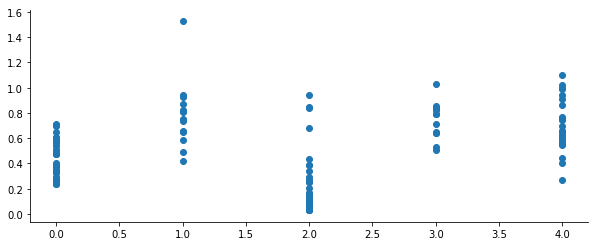

In [57]:
plt.scatter(histology_results.pattern, histology_results.membership);